In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import random
import scipy.stats as sts
pd.set_option('display.max_columns', 50)
from matplotlib.ticker import FormatStrFormatter
sns.set_style(style='whitegrid')

In [2]:
train = pd.read_csv('train_emission.csv').drop('Unnamed: 0', axis=1)
test = pd.read_csv('test_emission.csv').drop('Unnamed: 0', axis=1)

In [3]:
test16 = pd.read_csv('test_emission16.csv').drop('Unnamed: 0', axis=1)
test17 = pd.read_csv('test_emission17.csv').drop('Unnamed: 0', axis=1)
test19 = pd.read_csv('test_emission19.csv').drop('Unnamed: 0', axis=1)
test20 = pd.read_csv('test_emission20.csv').drop('Unnamed: 0', axis=1)

# Features transformation

In [4]:
cat_list = list(train.loc[:, 'College/University':'area_8'].columns)
X_train = train.iloc[:, 1:]
X_test = test.iloc[:, 1:]
X_test16 = test16.iloc[:, 1:]
X_test17 = test17.iloc[:, 1:]
X_test19 = test19.iloc[:, 1:]
X_test20 = test20.iloc[:, 1:]
y_train = train['TotalGHGEmissions'].apply(lambda x: np.log(1+x)).values
y_test = test['TotalGHGEmissions'].apply(lambda x: np.log(1+x)).values
y_test16 = test16['TotalGHGEmissions'].apply(lambda x: np.log(1+x)).values
y_test17 = test17['TotalGHGEmissions'].apply(lambda x: np.log(1+x)).values
y_test19 = test19['TotalGHGEmissions'].apply(lambda x: np.log(1+x)).values
y_test20 = test20['TotalGHGEmissions'].apply(lambda x: np.log(1+x)).values

In [5]:
def log_transform(x):
    return np.log(x + 1)
def square_transform(x):
    return x**2
def identity(x):
    return x

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
transformer_log = FunctionTransformer(log_transform)
transformer_square = FunctionTransformer(square_transform)
transformer_id = FunctionTransformer(identity)
scaler = StandardScaler()


In [7]:
# Transformation des features
numeric_preprocessor = Pipeline(steps=[('transformer', transformer_log), ('scaler', scaler)])
discret_preprocessor = Pipeline(steps=[('scaler', scaler)])
cat_preprocessor = Pipeline(steps=[('transformer', transformer_id)])
preprocessor = ColumnTransformer([('numerical', numeric_preprocessor, ['PropertyGFATotal', 'PropertyGFAParking']), 
                                  ('discret', discret_preprocessor, ['NumberofBuildings', 'NumberofFloors', 'building_age', 'electricity']), 
                                  ('categorical', cat_preprocessor, cat_list)])

In [8]:
features = []
for i in range(len(preprocessor.transformers)):
    features += preprocessor.transformers[i][2]

# Différents modèles
## Dummy regression

In [9]:
from sklearn.dummy import DummyRegressor
import time

dummy = DummyRegressor(strategy='mean')
pipe1 = make_pipeline(preprocessor, dummy)

start1 = time.process_time() 
pipe1.fit(X_train, y_train)
time1 = time.process_time() - start1 

print(f"Score for train set dummy regression : {dummy.score(X_train, y_train)} - Fit time : {time1}")
print(f"Score for test set dummy regression : {dummy.score(X_test, y_test)}")
result1 = [round(dummy.score(X_train, y_train), 3), round(time1, 4), round(dummy.score(X_test, y_test), 3)]

Score for train set dummy regression : 0.0 - Fit time : 0.020747999999999323
Score for test set dummy regression : -4.9348723471842604e-05


## Linear regression 

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)

estimator2 = LinearRegression()
pipe2 = make_pipeline(preprocessor, estimator2)
cv_results2 = cross_validate(pipe2, X_train, y_train, cv=cv, scoring='r2')
pipe2.fit(X_train, y_train);

In [11]:
print(f"Mean test score for the cross validation  : {cv_results2['test_score'].mean()} - Mean fit time : {cv_results2['fit_time'].mean()}")
print(f"Score for test set Linear regression : {pipe2.score(X_test, y_test)}")
result2 = [round(cv_results2['test_score'].mean(), 3), round(cv_results2['fit_time'].mean(), 4), round(pipe2.score(X_test, y_test), 3)]

Mean test score for the cross validation  : 0.8046948448853705 - Mean fit time : 0.014363813400268554
Score for test set Linear regression : 0.7824499062488038


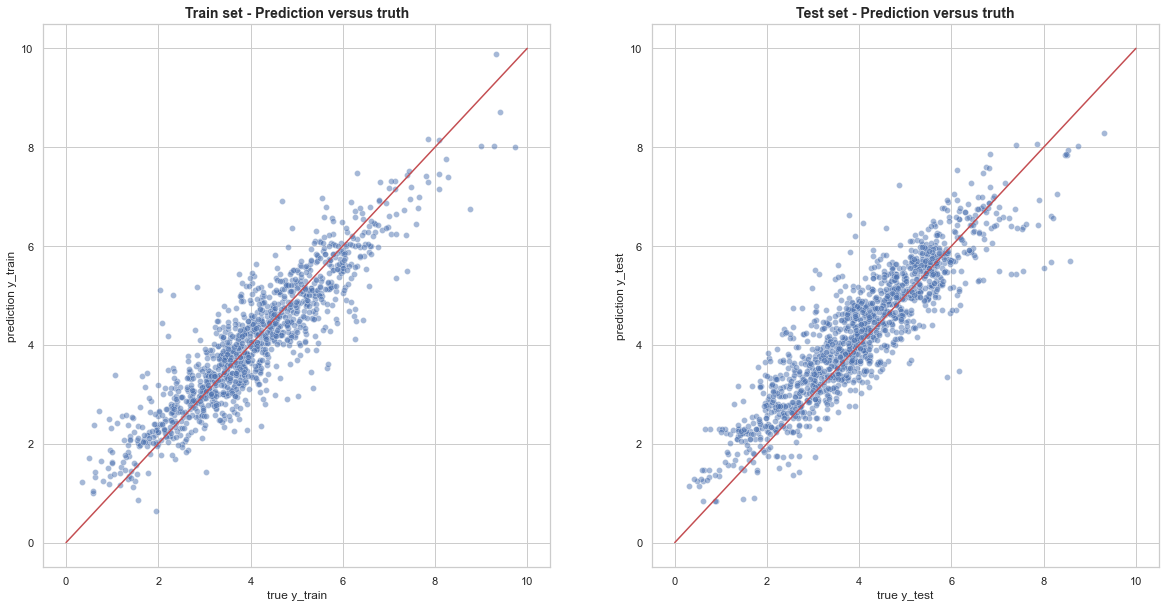

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.scatterplot(ax=ax[0], x=y_train, y=pipe2.predict(X_train), alpha=0.5)
sns.lineplot(ax=ax[0], x=[0, 10], y=[0, 10], color='r')
ax[0].set_xlabel('true y_train')
ax[0].set_ylabel('prediction y_train')
ax[0].set_title('Train set - Prediction versus truth', fontsize=14, weight='bold');

sns.scatterplot(ax=ax[1], x=y_test, y=pipe2.predict(X_test), alpha=0.5)
sns.lineplot(ax=ax[1], x=[0, 10], y=[0, 10], color='r')
ax[1].set_xlabel('true y_test')
ax[1].set_ylabel('prediction y_test')
ax[1].set_title('Test set - Prediction versus truth', fontsize=14, weight='bold');


In [13]:
fig.get_figure().savefig('linear_regression.pdf')

## Ridge

In [14]:
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
n_alphas = 200
alphas = {'ridge__alpha':list(np.linspace(0.05, 0.4, n_alphas))}

estimator3 = Ridge()
pipe3 = make_pipeline(preprocessor, estimator3)

#Création du gridsearch
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
grid_search3 = GridSearchCV(pipe3, param_grid=alphas, n_jobs=1, cv=cv, scoring='r2')
grid_search3.fit(X_train, y_train)
results3=pd.DataFrame(grid_search3.cv_results_)
best_score3 = max(results3['mean_test_score'])

fit_time3  = results3.loc[results3['mean_test_score']==best_score3, 'mean_fit_time'].values

In [15]:
print(f"Best mean test score : {best_score3} - Mean fit time : {fit_time3} - With the parameter : {grid_search3.best_params_}" )
print(f"Test set score : {r2_score(y_test, grid_search3.predict(X_test))}")
result3 = [round(best_score3, 3), round(fit_time3[0], 4), round(r2_score(y_test, grid_search3.predict(X_test)), 3)]

Best mean test score : 0.8056858324589372 - Mean fit time : [0.01083932] - With the parameter : {'ridge__alpha': 0.20301507537688446}
Test set score : 0.7825566918612559


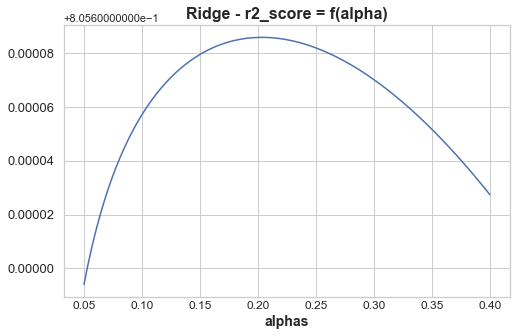

In [16]:
fig, ax1 = plt.subplots(figsize=(8, 5))
sns.lineplot(ax=ax1, data=pd.DataFrame(grid_search3.cv_results_), x='param_ridge__alpha', y='mean_test_score')
ax1.set_title('Ridge - r2_score = f(alpha)', fontsize=16, weight='bold')

ax1.tick_params(axis='x',labelsize=12, length=0.5, width='bold')
ax1.tick_params(axis='y',labelsize=13)
ax1.set_ylabel('')
ax1.set_xlabel('alphas', fontsize=14, weight='bold');

In [17]:
# Tracé des coefficients focntion de alpha
estimator4 = Ridge()
pipe4 = make_pipeline(preprocessor, estimator4)
alphas4 = list(np.logspace(-2, 6, n_alphas))
coefs4 = []
for a in alphas4:
    estimator4.set_params(alpha=a)
    pipe4.fit(X_train, y_train)
    coefs4.append(estimator4.coef_)

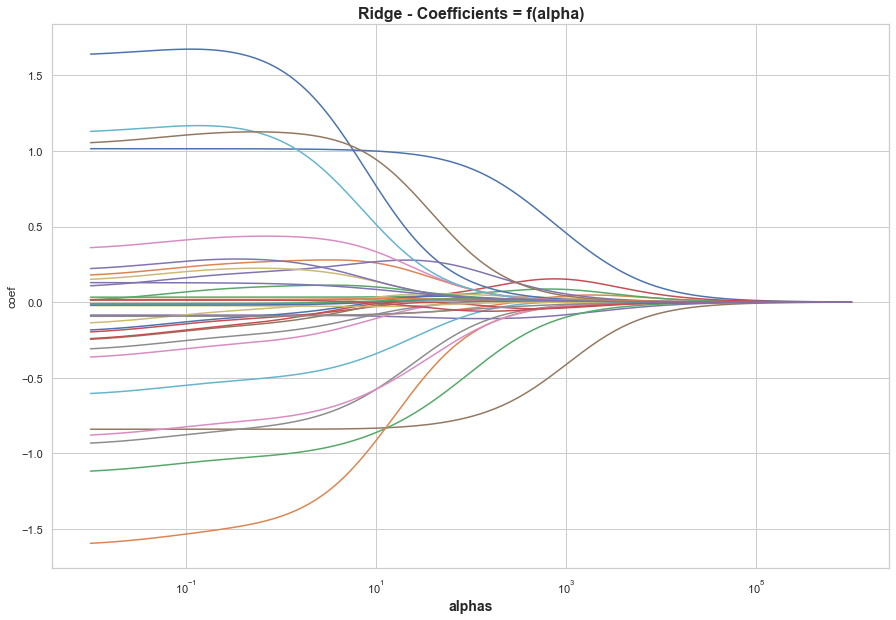

In [18]:
fig2, ax2 = plt.subplots(figsize=(15, 10))
ax2.plot(alphas4, coefs4)
ax2.set_xscale('log')
plt.xlabel('alphas', fontsize=14, weight='bold')
plt.ylabel('coef')
plt.title('Ridge - Coefficients = f(alpha)', fontsize=16, weight='bold');

## Lasso

In [19]:
from sklearn.linear_model import Lasso
n_alphas = 100
alphas5 = {'estimator5__alpha':list(np.linspace(0.0001, 0.0021, n_alphas))}

pipe5 = Pipeline([('preprocessor', preprocessor), ('estimator5', Lasso())])


#Création du gridsearch
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
grid_search5 = GridSearchCV(pipe5, param_grid=alphas5, n_jobs=1, cv=cv, scoring='r2')
grid_search5.fit(X_train, y_train)

results5=pd.DataFrame(grid_search5.cv_results_)
best_score5 = max(grid_search5.cv_results_['mean_test_score'])
fit_time5  = results5.loc[results5['mean_test_score']==best_score5, 'mean_fit_time'].values

In [20]:
print(f"Best mean test score : {best_score5} - Mean fit time : {fit_time5} - With the parameter : {grid_search5.best_params_}" )
print(f"Test set score : {r2_score(y_test, grid_search5.predict(X_test))}")
result5 = [round(best_score5, 3), round(fit_time5[0], 4), round(r2_score(y_test, grid_search5.predict(X_test)), 3)]

Best mean test score : 0.8065791670517802 - Mean fit time : [0.01097627] - With the parameter : {'estimator5__alpha': 0.0008474747474747475}
Test set score : 0.7822844476378507


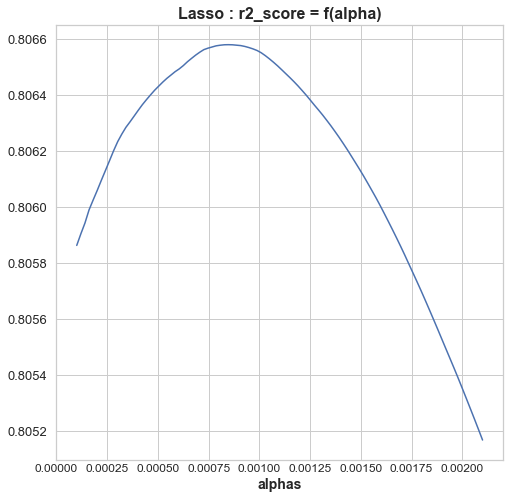

In [21]:
fig3, ax3 = plt.subplots(figsize=(8, 8))
sns.lineplot(ax=ax3, data=results5, x='param_estimator5__alpha', y='mean_test_score')
ax3.set_title('Lasso : r2_score = f(alpha)', fontsize=16, weight='bold')

ax3.tick_params(axis='x',labelsize=12, length=0.5, width='bold')
ax3.tick_params(axis='y',labelsize=13)
ax3.set_ylabel('')
ax3.set_xlabel('alphas', fontsize=14, weight='bold');

In [22]:
# Tracé des coefficients fonction de alpha
estimator6 = Lasso()
pipe6 = make_pipeline(preprocessor, estimator6)
alphas6 = list(np.logspace(-3, 1, n_alphas))
coefs6 = []
for a in alphas6:
    estimator6.set_params(alpha=a)
    pipe6.fit(X_train, y_train)
    coefs6.append(estimator6.coef_)

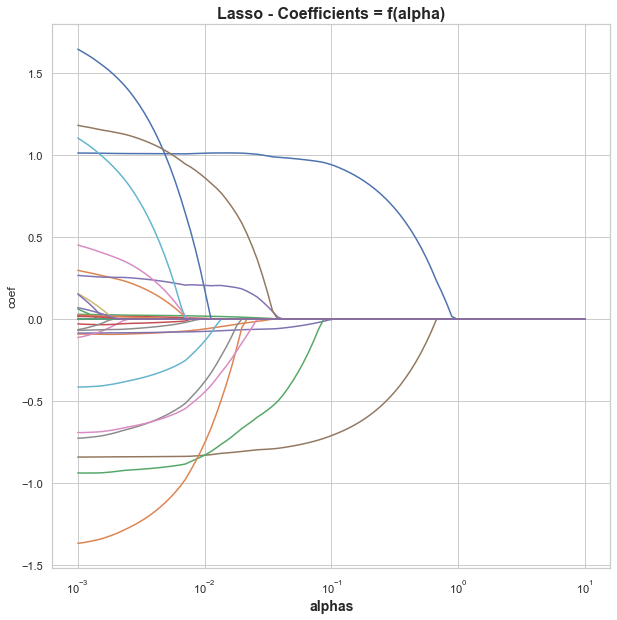

In [23]:
fig4, ax4 = plt.subplots(figsize=(10, 10))
ax4.plot(alphas6, coefs6)
ax4.set_xscale('log')
plt.ylabel('coef')
plt.title('Lasso - Coefficients = f(alpha)', fontsize=16, weight='bold')
ax4.set_xlabel('alphas', fontsize=14, weight='bold');

In [24]:
##Features non conservées par le Lasso
coefficients = grid_search5.best_estimator_.named_steps.estimator5.coef_
mask = (np.where(coefficients!=0, 1, 0))
mask = mask==1
pd.DataFrame(features)[~mask]

,0
15,Other - Entertainment/Public Assembly
20,Retail Store
23,Social/Meeting Hall
29,area_3
32,area_6


## ElasticNet

In [25]:
from sklearn.linear_model import ElasticNet
n_alphas = 50
alphas11 = {'estimator11__alpha':list(np.linspace(0.0001, 0.001, n_alphas)), 'estimator11__l1_ratio':[0.995, 1]}

pipe11 = Pipeline([('preprocessor', preprocessor), ('estimator11', ElasticNet())])

#Création du gridsearch
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
grid_search11 = GridSearchCV(pipe11, param_grid=alphas11, n_jobs=1, cv=cv, scoring='r2')
grid_search11.fit(X_train, y_train)

results11=pd.DataFrame(grid_search11.cv_results_)
best_score11 = max(grid_search11.cv_results_['mean_test_score'])
fit_time11  = results11.loc[results11['mean_test_score']==best_score11, 'mean_fit_time'].values

In [26]:
print(f"Best mean test score : {best_score11} - Mean fit time : {fit_time11} - With the parameter : {grid_search11.best_params_}" )
print(f"Test set score : {r2_score(y_test, grid_search11.predict(X_test))}")
result11 = [round(best_score11, 3), round(fit_time11[0], 4), round(r2_score(y_test, grid_search11.predict(X_test)), 3)]

Best mean test score : 0.8065789387850328 - Mean fit time : [0.01686859] - With the parameter : {'estimator11__alpha': 0.000853061224489796, 'estimator11__l1_ratio': 1}
Test set score : 0.7822795658199854


## SVR

In [27]:
from sklearn.svm import SVR
param_grid = {'estimator10__C': np.linspace(15, 25, 4),
    'estimator10__gamma' : np.linspace(0.01, 0.03, 4)}
estimator10 = SVR()
pipe10 = Pipeline([('preprocessor', preprocessor), ('estimator10', estimator10)])

#Création du gridsearch
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
grid_search10 = GridSearchCV(pipe10, param_grid=param_grid, n_jobs=1, cv=cv, scoring='r2')

grid_search10.fit(X_train, y_train);

In [28]:
results10=pd.DataFrame(grid_search10.cv_results_)
best_score10 = max(grid_search10.cv_results_['mean_test_score'])
fit_time10  = results10.loc[results10['mean_test_score']==best_score10, 'mean_fit_time'].values
print(f"Best mean test score : {best_score10} - Mean fit time : {fit_time10} - With the parameter : {grid_search10.best_params_}" )
print(f"Test set score : {r2_score(y_test, grid_search10.predict(X_test))}")
result10 = [round(best_score10, 3), round(fit_time10[0], 4), round(r2_score(y_test, grid_search10.predict(X_test)), 3)]

Best mean test score : 0.8212077495485227 - Mean fit time : [0.10379014] - With the parameter : {'estimator10__C': 15.0, 'estimator10__gamma': 0.03}
Test set score : 0.8029314779210777


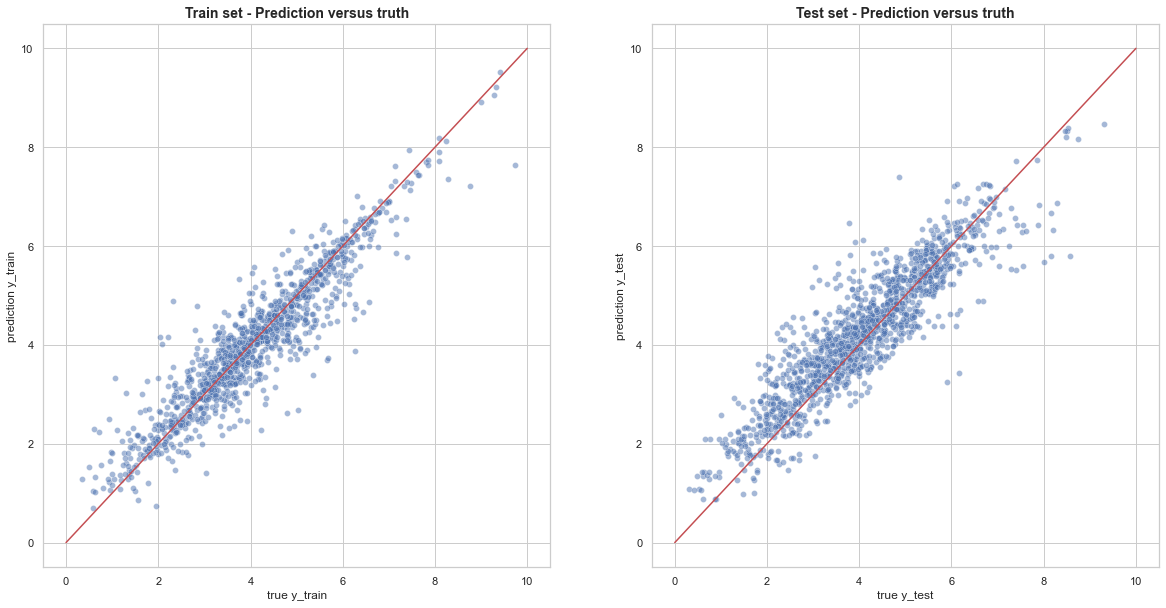

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.scatterplot(ax=ax[0], x=y_train, y=grid_search10.predict(X_train), alpha=0.5)
sns.lineplot(ax=ax[0], x=[0, 10], y=[0, 10], color='r')
ax[0].set_xlabel('true y_train')
ax[0].set_ylabel('prediction y_train')
ax[0].set_title('Train set - Prediction versus truth', fontsize=14, weight='bold');

sns.scatterplot(ax=ax[1], x=y_test, y=grid_search10.predict(X_test), alpha=0.5)
sns.lineplot(ax=ax[1], x=[0, 10], y=[0, 10], color='r')
ax[1].set_xlabel('true y_test')
ax[1].set_ylabel('prediction y_test')
ax[1].set_title('Test set - Prediction versus truth', fontsize=14, weight='bold');

## RandomForestRegressor

In [30]:
import shap
from sklearn.ensemble import RandomForestRegressor
param_grid = {'estimator7__n_estimators': [200, 300],
    'estimator7__max_depth' : [14, 16]}
estimator7 = RandomForestRegressor(criterion='squared_error', random_state=0)
pipe7 = Pipeline([('preprocessor', preprocessor), ('estimator7', estimator7)])

#Création du gridsearch
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
grid_search7 = GridSearchCV(pipe7, param_grid=param_grid, n_jobs=1, cv=cv, scoring='r2')

grid_search7.fit(X_train, y_train);

In [31]:
results7=pd.DataFrame(grid_search7.cv_results_)
best_score7 = max(grid_search7.cv_results_['mean_test_score'])
fit_time7  = results7.loc[results7['mean_test_score']==best_score7, 'mean_fit_time'].values
print(f"Best mean test score : {best_score7} - Mean fit time : {fit_time7} - With the parameter : {grid_search7.best_params_}" )
print(f"Test set score : {r2_score(y_test, grid_search7.predict(X_test))}")
result7 = [round(best_score7, 3), round(fit_time7[0], 4), round(r2_score(y_test, grid_search7.predict(X_test)), 3)]

Best mean test score : 0.7845138035363824 - Mean fit time : [1.49410605] - With the parameter : {'estimator7__max_depth': 16, 'estimator7__n_estimators': 300}
Test set score : 0.7441120578205043


## XGBoost

In [32]:
from xgboost import XGBRegressor
param_grid = {'estimator8__n_estimators': [25, 50, 75],
              'estimator8__max_depth' : [3, 4, 5], 
              'estimator8__eta': [0.1, 0.15, 0.2], 
              'estimator8__colsample_bytree': [0.5, 0.8, 1]}

estimator8 = XGBRegressor(random_state=0)
pipe8 = Pipeline([('preprocessor', preprocessor), ('estimator8', estimator8)])

#Création du gridsearch
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
grid_search8 = GridSearchCV(pipe8, param_grid=param_grid, n_jobs=1, cv=cv, scoring='r2')

grid_search8.fit(X_train, y_train);

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [33]:
results8=pd.DataFrame(grid_search8.cv_results_)
best_score8 = max(grid_search8.cv_results_['mean_test_score'])
fit_time8  = results8.loc[results8['mean_test_score']==best_score8, 'mean_fit_time'].values
print(f"Best mean test score : {best_score8} - Mean fit time : {fit_time8} - With the parameter : {grid_search8.best_params_}" )
print(f"Test set score : {r2_score(y_test, grid_search8.predict(X_test))}")
result8 = [round(best_score8, 3), round(fit_time8[0], 4), round(r2_score(y_test, grid_search8.predict(X_test)), 3)]

Best mean test score : 0.8193533289957806 - Mean fit time : [0.10182781] - With the parameter : {'estimator8__colsample_bytree': 0.8, 'estimator8__eta': 0.2, 'estimator8__max_depth': 3, 'estimator8__n_estimators': 75}
Test set score : 0.7868784177594127


## Features selection
### with ridge

In [34]:
from sklearn.feature_selection import RFECV
estimator91 = Ridge(alpha=1.12)
min_features_to_select = 1
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
selector91 = RFECV(estimator=estimator91,
                   step=1,
                   cv=cv,
                   scoring="r2",
                   min_features_to_select=min_features_to_select,)

#Création du pipeline
pipe91 = make_pipeline(preprocessor, selector91)

pipe91.fit(X_train, y_train)
print(pipe91.score(X_test, y_test))

0.772791919798445


 Best mean test score : 0.809323097771286
Optimal number of features : 17


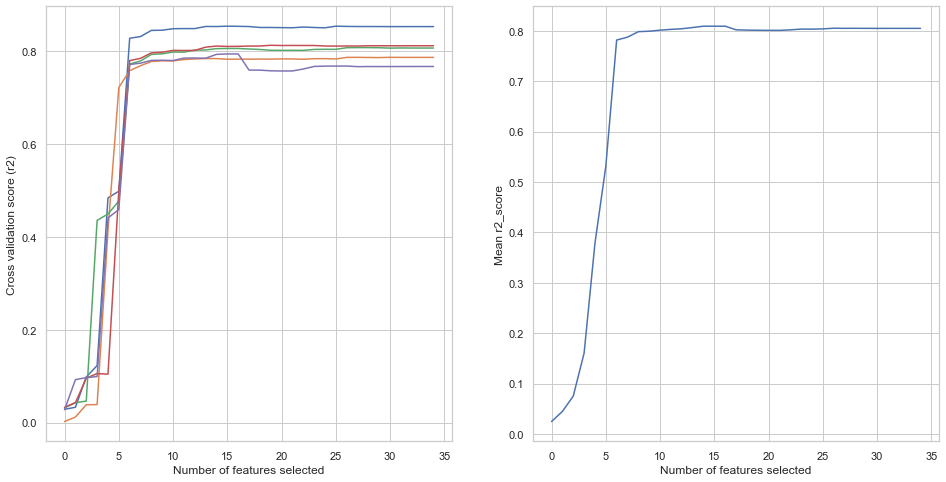

In [35]:
print(f" Best mean test score : {max(selector91.cv_results_['mean_test_score'])}")
print("Optimal number of features : %d" % selector91.n_features_)

# Plot number of features VS. cross-validation scores
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].set_xlabel("Number of features selected")
ax[0].set_ylabel("Cross validation score (r2)")
ax[0].plot( pd.DataFrame(selector91.cv_results_ ).iloc[:, 2:])
ax[1].set_xlabel("Number of features selected")
ax[1].set_ylabel("Mean r2_score")
ax[1].plot( pd.DataFrame(selector91.cv_results_ ).iloc[:, 0]);

### with XGBoost

In [36]:
estimator93 = XGBRegressor(n_estimators=75,
              max_depth=3, 
              eta=0.15, 
              colsample_bytree=0.5)
min_features_to_select = 1
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
selector93 = RFECV(estimator=estimator93,
           step=1,
           cv=cv,
           scoring="r2",
           min_features_to_select=min_features_to_select)

#Création du pipeline
pipe93 = make_pipeline(preprocessor, selector93)

pipe93.fit(X_train, y_train)
print(pipe93.score(X_train, y_train))
print(pipe93.score(X_test, y_test))

0.8903636955633113
0.7831576397098489


 Best mean test score : 0.821273095639581
Optimal number of features : 21


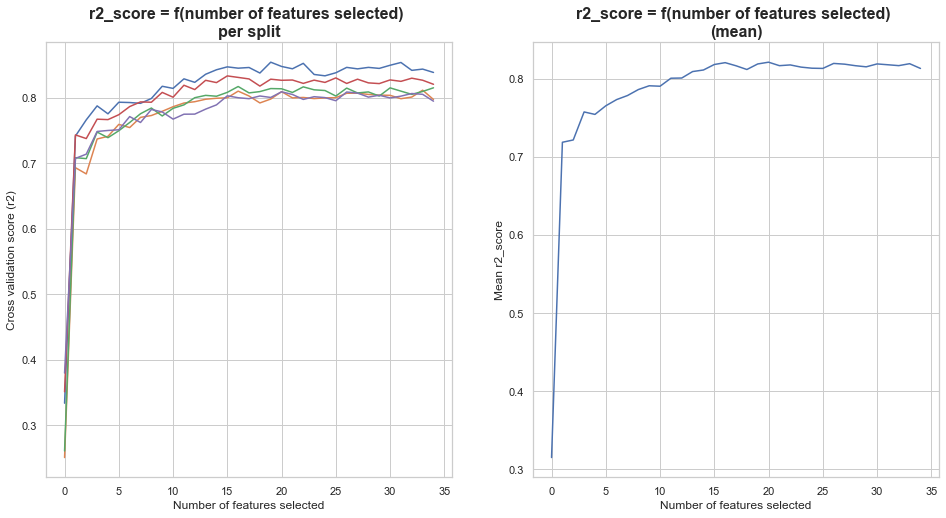

In [37]:
print(f" Best mean test score : {max(selector93.cv_results_['mean_test_score'])}")
print("Optimal number of features : %d" % selector93.n_features_)

# Plot number of features VS. cross-validation scores
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].set_xlabel("Number of features selected")
ax[0].set_ylabel("Cross validation score (r2)")
ax[0].plot( pd.DataFrame(selector93.cv_results_ ).iloc[:, 2:])
ax[0].set_title('r2_score = f(number of features selected) \nper split', fontsize=16, weight='bold')
ax[1].set_xlabel("Number of features selected")
ax[1].set_ylabel("Mean r2_score")
ax[1].plot( pd.DataFrame(selector93.cv_results_ ).iloc[:, 0])
ax[1].set_title('r2_score = f(number of features selected) \n(mean)', fontsize=16, weight='bold');

# Résultats
## Synthèse résultats par modèle

In [38]:
index = ['Dummy regression', 'Linear regression', 'Ridge regression', 'Lasso', 'Elastic Net', 'SVR', 'RandomForestRegressor', 'XGBoost']
columns = ['Best mean test (cross validation)', 'Mean fit time', 'Score for test set']
results = pd.DataFrame(index=index, columns=columns, data=np.vstack((result1, result2, result3, result5, result11, result10, result7, result8)))
results

,Best mean test (cross validation),Mean fit time,Score for test set
Dummy regression,0.000,0.0207,-0.000
Linear regression,0.805,0.0144,0.782
Ridge regression,0.806,0.0108,0.783
Lasso,0.807,0.0110,0.782
Elastic Net,0.807,0.0169,0.782
SVR,0.821,0.1038,0.803
RandomForestRegressor,0.785,1.4941,0.744
XGBoost,0.819,0.1018,0.787


In [39]:
#Choix de l'algorithme : SVR

# Avec la feature star score

In [40]:
# Modèle utilisé :  SVR, kernel gaussien

In [41]:
train_star = pd.read_csv('train_star_emission.csv').drop('Unnamed: 0', axis=1)
test_star = pd.read_csv('test_star_emission.csv').drop('Unnamed: 0', axis=1)

In [42]:
cat_list = list(train_star.loc[:, 'College/University':'area_8'].columns)
X_train_star = train_star.iloc[:, 1:]
X_test_star = test_star.iloc[:, 1:]
y_train_star = train_star['TotalGHGEmissions'].apply(lambda x: np.log(1+x)).values
y_test_star = test_star['TotalGHGEmissions'].apply(lambda x: np.log(1+x)).values


In [43]:
preprocessor1 = ColumnTransformer([('numerical', numeric_preprocessor, ['PropertyGFATotal', 'PropertyGFAParking']), 
                                  ('discret', discret_preprocessor, ['ENERGYSTARScore', 'electricity',
                                                                     'building_age', 'NumberofBuildings',  
                                                                     'NumberofFloors']), 
                           
                                   ('categorical', cat_preprocessor, cat_list)])

In [44]:
features_star = []
for i in range(len(preprocessor1.transformers)):
    features_star += preprocessor1.transformers[i][2]  

In [45]:
param_grid12 = {'estimator12__C': np.linspace(10, 20, 4),
    'estimator12__gamma' : np.linspace(0.005, 0.03, 4)}
estimator12 = SVR()
pipe12 = Pipeline([('preprocessor', preprocessor1), ('estimator12', estimator12)])

#Création du gridsearch
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
grid_search12 = GridSearchCV(pipe12, param_grid=param_grid12, n_jobs=1, cv=cv, scoring='r2')

grid_search12.fit(X_train_star, y_train_star);

In [46]:
results12=pd.DataFrame(grid_search12.cv_results_)
best_score12 = max(grid_search12.cv_results_['mean_test_score'])
fit_time12  = results12.loc[results12['mean_test_score']==best_score12, 'mean_fit_time'].values
print(f"Best mean test score : {best_score12} - Mean fit time : {fit_time12} - With the parameter : {grid_search12.best_params_}" )
print(f"Test set score : {r2_score(y_test_star, grid_search12.predict(X_test_star))}")
result12 = [round(best_score12, 3), round(fit_time12[0], 4), round(r2_score(y_test_star, grid_search12.predict(X_test_star)), 3)]

Best mean test score : 0.9243211305203332 - Mean fit time : [0.04306698] - With the parameter : {'estimator12__C': 20.0, 'estimator12__gamma': 0.013333333333333332}
Test set score : 0.8807725177983345


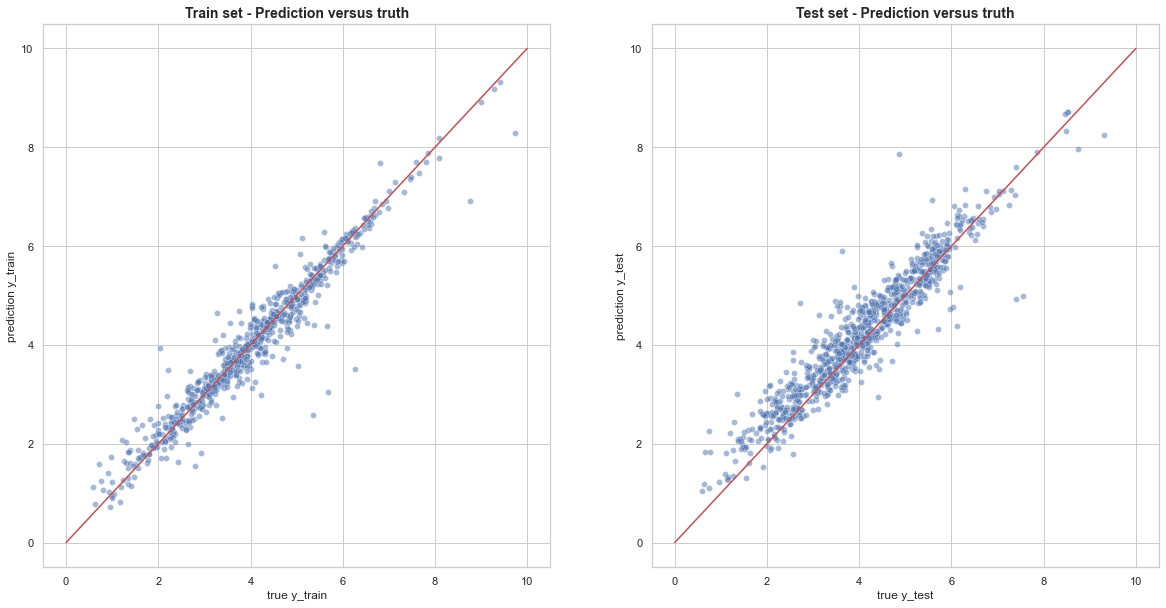

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.scatterplot(ax=ax[0], x=y_train_star, y=grid_search12.predict(X_train_star), alpha=0.5)
sns.lineplot(ax=ax[0], x=[0, 10], y=[0, 10], color='r')
ax[0].set_xlabel('true y_train')
ax[0].set_ylabel('prediction y_train')
ax[0].set_title('Train set - Prediction versus truth', fontsize=14, weight='bold');

sns.scatterplot(ax=ax[1], x=y_test_star, y=grid_search12.predict(X_test_star), alpha=0.5)
sns.lineplot(ax=ax[1], x=[0, 10], y=[0, 10], color='r')
ax[1].set_xlabel('true y_test')
ax[1].set_ylabel('prediction y_test')
ax[1].set_title('Test set - Prediction versus truth', fontsize=14, weight='bold');

# Résultats émission CO2

In [48]:
index = ['Dummy regression', 'Linear regression', 'Ridge regression', 
         'Lasso', 'Elastic Net', 'SVR', 'RandomForestRegressor', 'XGBoost', 'SVR avec star']
columns = ['Best mean test (cross validation)', 'Mean fit time', 'Score for test set']
results = pd.DataFrame(index=index, columns=columns, data=np.vstack((result1, result2, result3, result5, 
                                                                     result11, result10, result7, result8, result12)))
results

,Best mean test (cross validation),Mean fit time,Score for test set
Dummy regression,0.000,0.0207,-0.000
Linear regression,0.805,0.0144,0.782
Ridge regression,0.806,0.0108,0.783
Lasso,0.807,0.0110,0.782
Elastic Net,0.807,0.0169,0.782
SVR,0.821,0.1038,0.803
RandomForestRegressor,0.785,1.4941,0.744
XGBoost,0.819,0.1018,0.787
SVR avec star,0.924,0.0431,0.881


# Feature importance

In [49]:
import shap
X_train_transformed = pd.DataFrame(preprocessor.fit_transform(X_train), columns=features)
X_test_transformed = pd.DataFrame(preprocessor.fit_transform(X_test), columns=features)
X_train_transformed

,PropertyGFATotal,PropertyGFAParking,NumberofBuildings,NumberofFloors,building_age,electricity,College/University,Distribution Center,Hotel,K-12 School,Laboratory,Medical Office,Non-Refrigerated Warehouse,Office,Other,Other - Entertainment/Public Assembly,Other - Recreation,Parking,Refrigerated Warehouse,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Social/Meeting Hall,Strip Mall,Supermarket/Grocery Store,Worship Facility,area_1,area_2,area_3,area_4,area_5,area_6,area_7,area_8
0,1.107611,1.867230,-0.066349,1.532530,-0.337198,0.267102,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.843332,0.001109,0.0,0.0,0.155559,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.187568,1.460909,-0.066349,-0.499800,0.183330,-1.934728,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.338581,1.795184,-0.066349,-0.030801,-1.163972,1.125633,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.976701,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.023299,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.010919,2.099250,-0.066349,-0.187134,1.255069,-0.058555,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.624337,0.0,0.0,0.375663,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-0.437353,-0.501955,-0.066349,0.281865,1.408151,0.384514,0.0,0.0,0.0,0.0,0.0,0.000000,0.087437,0.513202,0.000000,0.0,0.0,0.000000,0.0,0.0,0.399361,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1203,-0.342216,-0.501955,-0.066349,-0.343467,-0.122917,-1.038358,0.0,0.0,0.0,0.0,0.0,0.021396,0.000000,0.020290,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.958314,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1204,-0.968817,-0.501955,-0.066349,-0.499800,0.030249,1.125634,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1205,-1.064615,-0.501955,-0.066349,-0.343467,0.305812,-2.229412,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1206,-0.729501,-0.501955,-0.066349,-0.030801,1.010105,0.110448,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.718878,0.000000,0.0,0.0,0.000000,0.0,0.0,0.281122,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Linear regression
### Coef

In [50]:
coef = pd.DataFrame(estimator2.coef_).rename(columns={0: 'coef' })
coef['features'] = features
coef ['valeur_absolue_coef'] = abs(coef['coef'])
coef.sort_values('valeur_absolue_coef', ascending=False).iloc[:15, :]

,coef,features,valeur_absolue_coef
10,1.626746,Laboratory,1.626746
21,-1.612285,Self-Storage Facility,1.612285
12,-1.133794,Non-Refrigerated Warehouse,1.133794
19,1.115343,Restaurant,1.115343
25,1.039218,Supermarket/Grocery Store,1.039218
0,1.014725,PropertyGFATotal,1.014725
7,-0.948723,Distribution Center,0.948723
26,-0.895452,Worship Facility,0.895452
5,-0.841033,electricity,0.841033
9,-0.620511,K-12 School,0.620511


### Valeur de shapley - Globalement

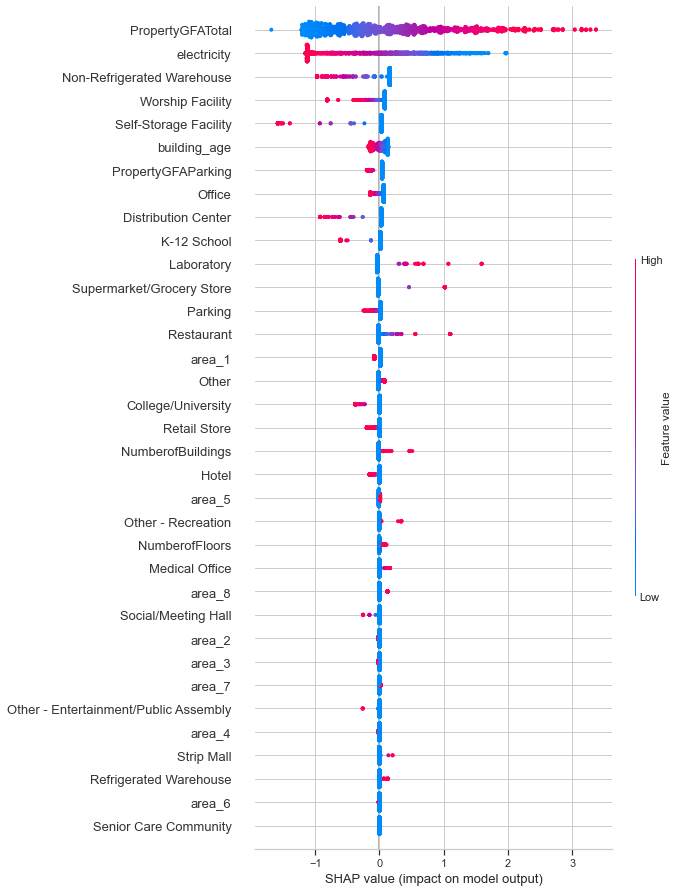

In [51]:
lin_reg_explainer1 = shap.LinearExplainer(estimator2, X_train_transformed)
shap.summary_plot(lin_reg_explainer1.shap_values(X_test_transformed),
                  features = X_test_transformed,max_display=36, show=False)
plt.gcf().axes[-1].set_aspect(200)
plt.gcf().axes[-1].set_box_aspect(500)

### Valeur de shapley - par bâtiment

College/University                       0.0
Distribution Center                      0.0
Hotel                                    0.0
K-12 School                              0.0
Laboratory                               0.0
Medical Office                           0.0
Non-Refrigerated Warehouse               0.0
Office                                   0.0
Other                                    0.0
Other - Entertainment/Public Assembly    0.0
Other - Recreation                       0.0
Parking                                  0.0
Refrigerated Warehouse                   0.0
Restaurant                               0.0
Retail Store                             1.0
Self-Storage Facility                    0.0
Senior Care Community                    0.0
Social/Meeting Hall                      0.0
Strip Mall                               0.0
Supermarket/Grocery Store                0.0
Worship Facility                         0.0
Name: 876, dtype: float64


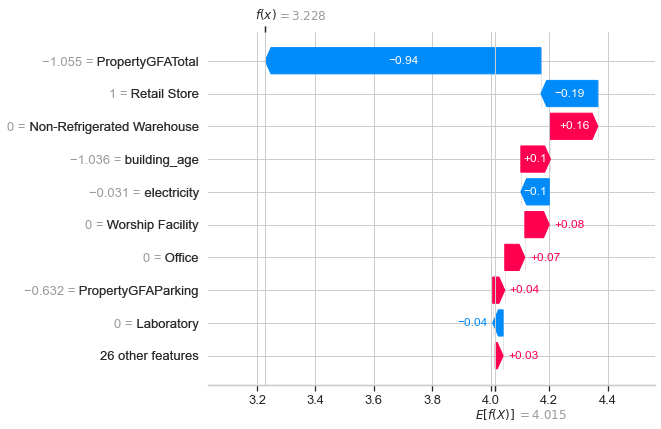

None


In [52]:
i = random.randint(0, len(X_test_transformed))
shap_values = lin_reg_explainer1(X_test_transformed[i:i+1])
shap_values.feature_names = features
print(X_test_transformed.iloc[i, 6:27])
print(shap.waterfall_plot(shap_values[0], max_display=10))

## SVR sans star


In [53]:
X_train_transformed = pd.DataFrame(preprocessor.fit_transform(X_train), columns=features)
X_test_transformed = pd.DataFrame(preprocessor.fit_transform(X_test), columns=features)

In [54]:
estimator10.fit(X_train_transformed, y_train)
explainer = shap.Explainer(estimator10.predict, X_train_transformed)

### Valeur de Shapley par batiment

Permutation explainer: 2it [00:10, 10.54s/it]               


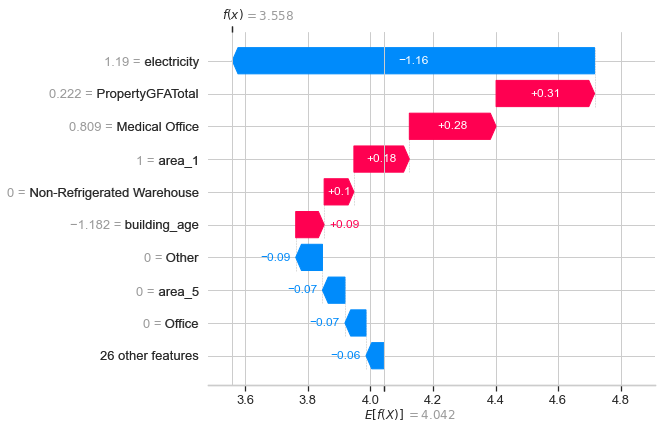

In [55]:

i = random.randint(0, len(X_test_transformed))
shap_values = explainer(pd.DataFrame(X_test_transformed)[i:i+1])
shap_values.feature_names = features
(shap.waterfall_plot(shap_values[0], max_display=10))



## SVR avec star

In [56]:
X_train_star_transformed = pd.DataFrame(preprocessor1.fit_transform(X_train_star), columns=features_star)
X_test_star_transformed = pd.DataFrame(preprocessor1.fit_transform(X_test_star), columns=features_star)


In [57]:
estimator12.fit(X_train_star_transformed, y_train_star)
explainer2 = shap.Explainer(estimator12.predict, X_train_star_transformed)

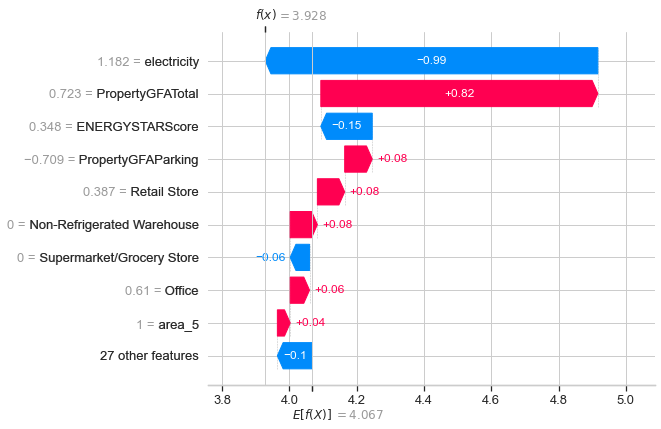

In [58]:
i = random.randint(0, len(X_test_star_transformed))
shap_values = explainer2(pd.DataFrame(X_test_star_transformed)[i:i+1])
shap_values.feature_names = features_star
(shap.waterfall_plot(shap_values[0], max_display=10))
